## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 7130089.88it/s]


Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 29411946.44it/s]


Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 7436654.14it/s]


Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [307]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.2),
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [308]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 128]         100,480
       BatchNorm1d-4                  [-1, 128]             256
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
       LogSoftmax-10                   [-1, 10]               0
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.42
Estimated T

C:\Users\Jesar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Your experiments come here:

In [309]:
# Your experiments, training and validation loops here
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_func = nn.functional.cross_entropy
loss_history = []
epochs = 10
for ep in range(0, epochs):
    for img, label in train_loader:
        opt.zero_grad()
        y_pred = model.forward(img.to(device))
        loss = loss_func(y_pred, label.to(device))
        loss.backward()
        opt.step()
        loss_history.append(loss)

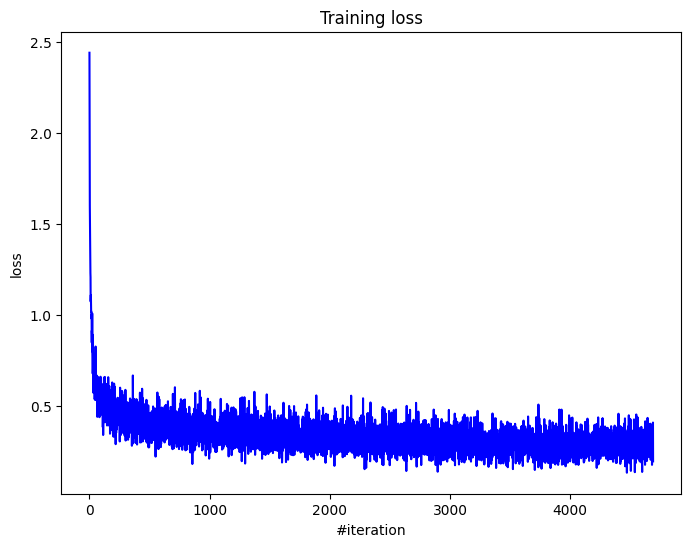

In [310]:
plt.figure(figsize=(8, 6))        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(torch.tensor(loss_history).cpu(), 'b')
plt.show()

In [311]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_predicted = model.forward(batch_x.reshape(-1, 784).to(device))
        predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
        real_labels.append(torch.tensor(batch_y.reshape(-1)))
predicted_labels = torch.cat(predicted_labels).to(device)
real_labels = torch.cat(real_labels).to(device)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\2867063785.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\2867063785.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_labels.append(torch.tensor(batch_y.reshape(-1)))


In [312]:
test_acc

tensor(0.8860)

Получили acc = 0.886

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [521]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 312),
            nn.ReLU(),
            nn.Linear(312, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Softmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [522]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 312]         244,920
              ReLU-3                  [-1, 312]               0
            Linear-4                  [-1, 200]          62,600
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
           Softmax-9                   [-1, 10]               0
Total params: 328,630
Trainable params: 328,630
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.25
Estimated Total Size (MB): 1.27
-------------------------------------------

In [523]:

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_func = nn.functional.cross_entropy
loss_history = []
acc_history = []
epochs = 3
for ep in range(0, epochs):
    for img, label in train_loader:
        opt.zero_grad()
        y_pred = model.forward(img[:64].to(device))
        loss = loss_func(y_pred, label[:64].to(device))
        loss.backward()
        opt.step()
        loss_history.append(loss)
        train_acc = (y_pred.argmax(axis=1) == label[:64].to(device)).type(torch.FloatTensor).mean()
        acc_history.append(train_acc)

# Your experiments, come here

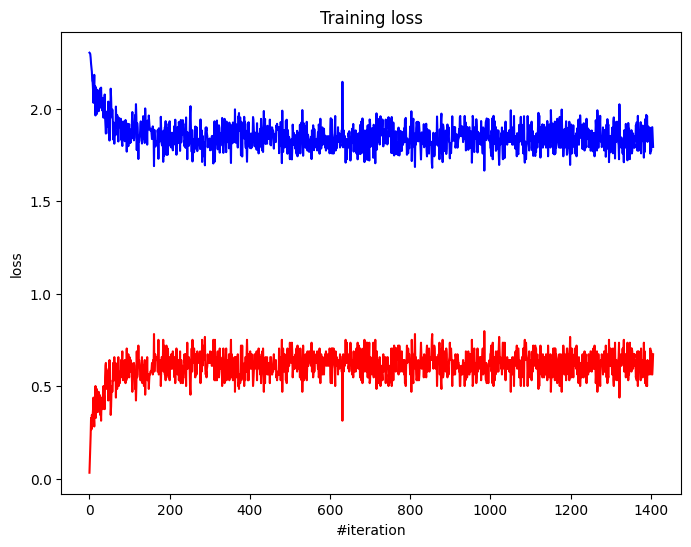

In [524]:
plt.figure(figsize=(8, 6))        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(torch.tensor(loss_history).cpu(), 'b')
plt.plot(torch.tensor(acc_history).cpu(), 'r')
plt.show()

In [525]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_predicted = model.forward(batch_x.to(device))
        predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
        real_labels.append(torch.tensor(batch_y.reshape(-1)))
predicted_labels = torch.cat(predicted_labels).to(device)
real_labels = torch.cat(real_labels).to(device)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\3848766310.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\3848766310.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_labels.append(torch.tensor(batch_y.reshape(-1)))


In [526]:
print(test_acc)
print(train_acc)

tensor(0.6090)
tensor(0.6719)


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [530]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Dropout(0.2),
            nn.Linear(input_shape, 312),
            nn.BatchNorm1d(312),
            nn.ReLU(),
            nn.Linear(312, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Softmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [531]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 312]         244,920
       BatchNorm1d-4                  [-1, 312]             624
              ReLU-5                  [-1, 312]               0
            Linear-6                  [-1, 200]          62,600
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
            Linear-9                  [-1, 100]          20,100
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
          Softmax-12                   [-1, 10]               0
Total params: 329,654
Trainable params: 329,654
Non-trainable params: 0
-------------------------------

In [532]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_func = nn.functional.cross_entropy
loss_history = []
acc_history = []
epochs = 3
for ep in range(0, epochs):
    for img, label in train_loader:
        opt.zero_grad()
        y_pred = model.forward(img[:64].to(device))
        loss = loss_func(y_pred, label[:64].to(device))
        loss.backward()
        opt.step()
        loss_history.append(loss)
        train_acc = (y_pred.argmax(axis=1) == label[:64].to(device)).type(torch.FloatTensor).mean()
        acc_history.append(train_acc)

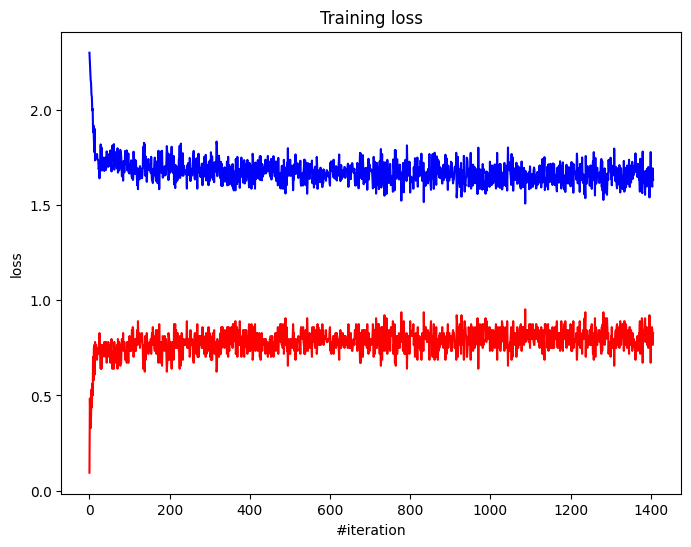

In [533]:
plt.figure(figsize=(8, 6))        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(torch.tensor(loss_history).cpu(), 'b')
plt.plot(torch.tensor(acc_history).cpu(), 'r')
plt.show()

In [534]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_predicted = model.forward(batch_x.to(device))
        predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
        real_labels.append(torch.tensor(batch_y.reshape(-1)))
predicted_labels = torch.cat(predicted_labels).to(device)
real_labels = torch.cat(real_labels).to(device)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\3848766310.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_labels.append(torch.tensor(y_predicted.argmax(axis=1)))
C:\Users\Jesar\AppData\Local\Temp\ipykernel_11268\3848766310.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_labels.append(torch.tensor(batch_y.reshape(-1)))


In [535]:
print("Train acc: ", train_acc)
print("Test acc: ", test_acc)

Train acc:  tensor(0.8281)
Test acc:  tensor(0.8117)


### Conclusions:
_Write down small report with your conclusions and your ideas._

Попробовав различные слои в тренировке на fashion mnist, стало понятно, что использовать logsoftmax в данном случае лучшая идея, также особо не надо усложнять сеть множеством слоёв, которые особо не поднимают test_acc. Затем мы переобучили модель используя несколько слоёв, функций активации и не используя слои Dropout и Batchnorm, что привело к среднему acc на train сете и ещё хуже acc на test сете. Затем мы частично решили данную проблему, использовав, Dropout перед всеми слоями и затем Batchnorm в двух местах, наш acc поднялся до примерно 0.82 на тесте и трейне, что является существенным приростом. Таким образом Dropout и Batchnorm помогают избегать переобучения, без них совсем плохо с точностью.